In [296]:
### PREREQUISTIES
### (many used only in one notebook...)

import os
import pandas as pd
import numpy as np
import logging ### to monitor the code
from bs4 import BeautifulSoup
import pickle
import math
import random
import sys
import csv
import unicodedata
import requests
import re

import nltk
from nltk.collocations import *

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

import xml.etree.cElementTree as ET
from urllib.request import urlopen

import gspread
from gspread_dataframe import get_as_dataframe, set_with_dataframe
#from google.colab import auth
#from oauth2client.client import GoogleCredentials
from google.oauth2 import service_account # based on google-auth library
import sddk

In [297]:
#!pip install anda
#from anda import gr ### the import takes substantial time, since it import a +600MB file containing ancient Greek dictionary

In [298]:
### not neccessary for reading the data, just for exporting them to sciencedata.dk
conf = sddk.configure()

sciencedata.dk username (format '123456@au.dk'): 648597@au.dk
sciencedata.dk password: ········
endpoint variable has been configured to: https://sciencedata.dk/files/


In [299]:
# to access gsheet, you need Google Service Account key json file
# I have mine located in my personal space on sciencedata.dk, so I read it from there:

# (1) read the file and parse its content
file_data = conf[0].get(conf[1] + "ServiceAccountsKey.json").json()
# (2) transform the content into crendentials object
credentials = service_account.Credentials.from_service_account_info(file_data)
# (3) specify your usage of the credentials
scoped_credentials = credentials.with_scopes(['https://spreadsheets.google.com/feeds', 'https://www.googleapis.com/auth/drive'])
# (4) use the constrained credentials for authentication of gspread package
gc = gspread.Client(auth=scoped_credentials)
# (5) establish connection with spreadsheets specified by their url
PIA_data = gc.open_by_url("https://docs.google.com/spreadsheets/d/1KxOx7Be9fj3lDcEPgQhQ-Iqcn9p367-MMD6RMXe8rks/edit?usp=sharing")
PIA_overview = gc.open_by_url("https://docs.google.com/spreadsheets/d/1e94wyelg6dftQ4zxbq1xvwxWAI-BhcYXtclDW-YTnrw/edit?usp=sharing")

In [300]:
### our data are located within a publicly available folder on sciencedata.dk
publicfolder = "31b393e2afe1ee96ce81869c7efe18cb"
c_aristotelicum = sddk.read_file("c_aristotelicum_repl.json", "df", publicfolder)
c_hippocraticum = sddk.read_file("c_hippocraticum_repl.json", "df", publicfolder)

reading file located in a public folder
reading file located in a public folder


In [301]:
# replace title on the basis of manual coding
c_hip_metadata = PIA_overview.worksheet("c_hip_metadata").get_all_records()
c_hip_title_dict = {pair["doc_id"] : pair["title_latin"] for pair in c_hip_metadata}
c_hippocraticum["title"] = c_hippocraticum.apply(lambda row: c_hip_title_dict[row["doc_id"]], axis=1)

In [302]:
# replace title on the basis of manual coding
c_arist_metadata = PIA_overview.worksheet("c_arist_metadata").get_all_records()
c_arist_title_dict = {pair["doc_id"] : pair["title_latin"] for pair in c_arist_metadata}
c_aristotelicum["title"] = c_aristotelicum.apply(lambda row: c_arist_title_dict[row["doc_id"]], axis=1)

In [304]:
c_hippocraticum.head(5)

,filename,author,title,string,wordcount,author_id,doc_id,raw_date,date_avr,date_probs,date_manual,provenience,sentences,lemmata,lemmata_wordcount,lemmatized_sentences,n_sentences,lemmata_repl,lemmatized_sentences_repl
1039,tlg0627.tlg001.perseus-grc1.xml,Hippocrates,De prisca medicina,ὁπόσοι μὲν ἐπεχείρησαν περὶ ἰητρικῆς λέγειν ἢ ...,5534,tlg0627,tlg0627.tlg001,5-4 B.C.,-4.0,"{'-4.5': 0.5, '-3.5': 0.5}",-3.5,pagan,[ὁπόσοι μὲν ἐπεχείρησαν περὶ ἰητρικῆς λέγειν ἢ...,"[ὁπόσος, ἐπιχειρέω, ἰητρικῆς, λέγω, γράφω, ὑπό...",2456,"[[ὁπόσος, ἐπιχειρέω, ἰητρικῆς, λέγω, γράφω, ὑπ...",259,"[ὁπόσος, ἐπιχειρέω, ἰητρικῆς, λέγω, γράφω, ὑπό...","[[ὁπόσος, ἐπιχειρέω, ἰητρικῆς, λέγω, γράφω, ὑπ..."
1040,tlg0627.tlg002.perseus-grc1.xml,Hippocrates,De aëre aquis et locis,"ἰητρικὴν ὅστις βούλεται ὀρθῶς ζητεῖν, τάδε χρὴ...",7502,tlg0627,tlg0627.tlg002,5-4 B.C.,-4.0,"{'-4.5': 0.5, '-3.5': 0.5}",-3.5,pagan,"[ἰητρικὴν ὅστις βούλεται ὀρθῶς ζητεῖν, τάδε χρ...","[ἰητρικην, βούλομαι, ὀρθός, ζητέω, χρῆ, ποιέω,...",3378,"[[ἰητρικην, βούλομαι, ὀρθός, ζητέω, χρῆ, ποιέω...",462,"[ἰητρικην, βούλομαι, ὀρθός, ζητέω, χρῆ, ποιέω,...","[[ἰητρικην, βούλομαι, ὀρθός, ζητέω, χρῆ, ποιέω..."
1041,tlg0627.tlg003.perseus-grc1.xml,Hippocrates,Prognosticon,τὸν ἰητρὸν δοκέει μοι ἄριστον εἶναι πρόνοιαν ἐ...,5217,tlg0627,tlg0627.tlg003,5-4 B.C.,-4.0,"{'-4.5': 0.5, '-3.5': 0.5}",-3.5,pagan,[τὸν ἰητρὸν δοκέει μοι ἄριστον εἶναι πρόνοιαν ...,"[ἰατρός, δοκέω, ἁμός, ἄριστον, πρόνοια, ἐπιτηδ...",2481,"[[ἰατρός, δοκέω, ἁμός, ἄριστον, πρόνοια, ἐπιτη...",303,"[ἰατρός, δοκέω, ἁμός, ἄριστον, πρόνοια, ἐπιτηδ...","[[ἰατρός, δοκέω, ἁμός, ἄριστον, πρόνοια, ἐπιτη..."
1042,tlg0627.tlg004.perseus-grc1.xml,Hippocrates,De diaeta in morbis acutis,"οἱ ξυγγράψαντες τὰς Κνιδίας καλεομένας γνώμας,...",6128,tlg0627,tlg0627.tlg004,5-4 B.C.,-4.0,"{'-4.5': 0.5, '-3.5': 0.5}",-3.5,pagan,[οἱ ξυγγράψαντες τὰς Κνιδίας καλεομένας γνώμας...,"[ξυγγράψαντες, Κνίδιος, γνώμη, ὁποῖος, πάσχω, ...",2973,"[[ξυγγράψαντες, Κνίδιος, γνώμη, ὁποῖος, πάσχω,...",370,"[ξυγγράψαντες, Κνίδιος, γνώμη, ὁποῖος, πάσχω, ...","[[ξυγγράψαντες, Κνίδιος, γνώμη, ὁποῖος, πάσχω,..."
1043,tlg0627.tlg005.perseus-grc1.xml,Hippocrates,De diaeta acutorum (Sp.),"καῦσος γίγνεται, ὁκόταν ἀναξηρανθέντα τὰ φλέβι...",5218,tlg0627,tlg0627.tlg005,5-4 B.C.,-4.0,"{'-4.5': 0.5, '-3.5': 0.5}",-3.5,pagan,"[καῦσος γίγνεται, ὁκόταν ἀναξηρανθέντα τὰ φλέβ...","[καῦσος, γίγνομαι, ὁκόταν, φλέβια, θερινός, ὥρ...",2899,"[[καῦσος, γίγνομαι, ὁκόταν, φλέβια, θερινός, ὥ...",351,"[καῦσος, γίγνομαι, ὁκόταν, φλέβια, θερινός, ὥρ...","[[καῦσος, γίγνομαι, ὁκόταν, φλέβια, θερινός, ὥ..."


In [305]:
# patterns used in the replacement
keyterm_patterns = [("^λ[υ|ύ]π.+", "λύπ*"), ("^[ἀ|ἄ]λγ.+", "ἄλγ*"), ("^[ὀ|ὠ]δ[ύ|υ]ν.", "ὀδύν*"), ("^π[ό|ο]ν[ο|ό|έ|ε|η|ή|ῆ](?!ρ).+", "πόνο*")]

In [306]:
# make overview columns of individual terms accross documents
for pattern_tuple in keyterm_patterns:
    term = pattern_tuple[1] # eg. "λύπ*"
    c_aristotelicum[term] =  c_aristotelicum.apply(lambda row: row["lemmata_repl"].count(term), axis=1)
    c_hippocraticum[term] =  c_hippocraticum.apply(lambda row: row["lemmata_repl"].count(term), axis=1)
c_aristotelicum["terms_sum"] = c_aristotelicum.apply(lambda row: (row["λύπ*"] + row["ἄλγ*"] + row["ὀδύν*"] + row["πόνο*"]), axis=1)
c_hippocraticum["terms_sum"] = c_hippocraticum.apply(lambda row: (row["λύπ*"] + row["ἄλγ*"] + row["ὀδύν*"] + row["πόνο*"]), axis=1)

In [307]:
c_aristotelicum[["λύπ*", "ἄλγ*", "ὀδύν*", "πόνο*"]].sum()

λύπ*     391
ἄλγ*      32
ὀδύν*      3
πόνο*    100
dtype: int64

In [308]:
c_hippocraticum[["λύπ*", "ἄλγ*", "ὀδύν*", "πόνο*"]].sum()

λύπ*      58
ἄλγ*     315
ὀδύν*    642
πόνο*    651
dtype: int64

In [309]:
for term in ["λύπ*", "ἄλγ*", "ὀδύν*", "πόνο*"]:
    c_aristotelicum[term + "_TF"] = c_aristotelicum.apply(lambda row: np.round(row[term] / row["wordcount"], 6), axis=1)
    c_hippocraticum[term + "_TF"] = c_hippocraticum.apply(lambda row: np.round(row[term] / row["wordcount"], 6), axis=1)
c_aristotelicum["TF_sum"] = c_aristotelicum.apply(lambda row: np.round((row["λύπ*"] + row["ἄλγ*"] + row["ὀδύν*"] + row["πόνο*"]) / row["wordcount"], 6), axis=1)
c_hippocraticum["TF_sum"] = c_hippocraticum.apply(lambda row: np.round((row["λύπ*"] + row["ἄλγ*"] + row["ὀδύν*"] + row["πόνο*"]) / row["wordcount"], 6), axis=1)

# Selected works

In [310]:
# in what follows, we mainly focus upon a subselection of works from the two corpora
# we believe that these subselected works coverepresent the most relevant texts dealing with the topic of pain

ar_sel = ["tlg0086.tlg003", "tlg0086.tlg009", "tlg0086.tlg010", "tlg0086.tlg012", "tlg0086.tlg014", "tlg0086.tlg020", "tlg0086.tlg021", "tlg0086.tlg025", "tlg0086.tlg035", "tlg0086.tlg038"]
hip_sel = ["tlg0627.tlg001", "tlg0627.tlg003", "tlg0627.tlg006", "tlg0627.tlg009", "tlg0627.tlg012", "tlg0627.tlg017", "tlg0627.tlg019", "tlg0627.tlg031", "tlg0627.tlg032", "tlg0627.tlg033"]

In [311]:
# use these to filter within our dataframe
c_aristotelicum_10 = c_aristotelicum[c_aristotelicum["doc_id"].isin(ar_sel)]
c_hippocraticum_10 = c_hippocraticum[c_hippocraticum["doc_id"].isin(hip_sel)]

/home/kasev/.local/lib/python3.6/site-packages/IPython/core/pylabtools.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


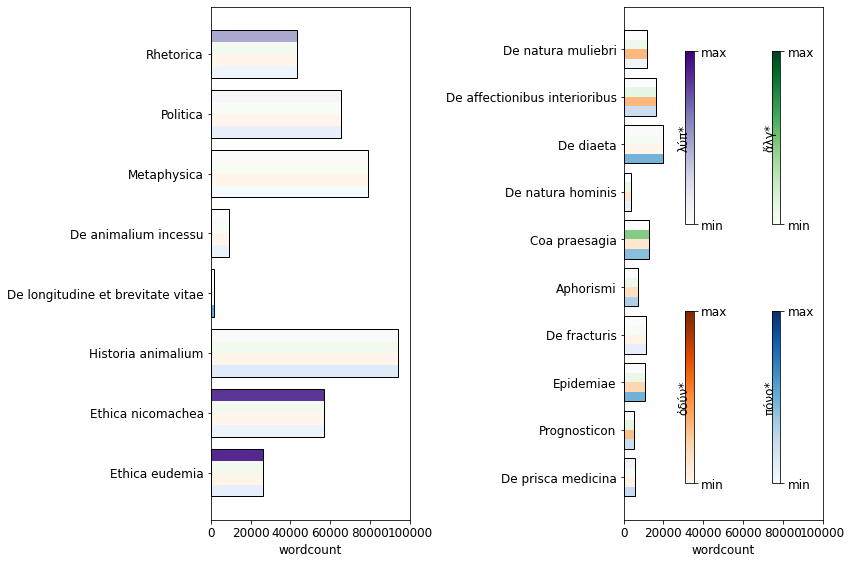

In [312]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm


# alternatively, choose 10 workds with maximal weighted sum of pain terms
#c_aristotelicum_10 = c_aristotelicum.sort_values("weighted_sum", ascending=False)[:10][::-1]
#c_hippocraticum_10 = c_hippocraticum.sort_values("weighted_sum", ascending=False)[:10][::-1]

# preproducing the figure object
fig, [ax1, ax2] = plt.subplots(1,2, figsize=(12, 8), tight_layout=True)

# CORPUS ARISTOTELICUM
labels = [title.partition(";")[0].partition(".")[0] for title in c_aristotelicum_10["title"].tolist()]
wordcounts = c_aristotelicum_10["wordcount"]
y = np.arange(len(labels))  # the label locations
width = 0.2  # the width of the bars

bar_location = 0
for keyterm, colormap in [("λύπ*", "Purples"), ("ἄλγ*", "Greens"), ("ὀδύν*", "Oranges"),	("πόνο*", "Blues")]:
  coloring = c_aristotelicum_10[keyterm + "_TF"] / c_aristotelicum_10["TF_sum"].max()
  ax1.barh(y + 0.3 - bar_location, wordcounts, width, color=plt.get_cmap(colormap)(coloring), label=keyterm)
  bar_location = bar_location + 0.2
ax1.barh(y, wordcounts, width * 4, color="none", edgecolor="black")
#rects2 = ax.barh(x + width/2, lemmata_wordcounts_1, width, label='Women')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax1.set_xlabel("wordcount")
#ax1.set_ylabel("documents")
ax1.set_yticks(y)
ax1.set_yticklabels(labels)
ax1.set_xlim(0, 100000)
# ax.legend()

# CORPUS HIPPOCRATICUM
labels = [title.partition(";")[0].partition(".")[0] for title in c_hippocraticum_10["title"].tolist()]
wordcounts = c_hippocraticum_10["wordcount"]
y = np.arange(len(labels))  # the label locations
width = 0.2  # the width of the bars

bar_location = 0
for keyterm, colormap in [("λύπ*", "Purples"), ("ἄλγ*", "Greens"), ("ὀδύν*", "Oranges"),	("πόνο*", "Blues")]:
  coloring = c_hippocraticum_10[keyterm + "_TF"] / c_hippocraticum_10["TF_sum"].max()
  cmap = plt.get_cmap(colormap)
  ax2.barh(y + 0.3 - bar_location, wordcounts, width, color=cmap(coloring), label=keyterm)
  bar_location = bar_location + 0.2



ax2.barh(y, wordcounts, width * 4, color="none", edgecolor="black")


#rects2 = ax.barh(x + width/2, lemmata_wordcounts_1, width, label='Women')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax2.set_xlabel("wordcount")
#ax2.set_ylabel("documents")
ax2.set_yticks(y)
ax2.set_yticklabels(labels)
ax2.set_xlim(0, 100000)
# ax.legend()

cblocs =    [[0.8, 0.6, 0.01, 0.3],# [left, bottom, width, height]
             [0.9, 0.6, 0.01, 0.3],
             [0.8, 0.15, 0.01, 0.3],
             [0.9, 0.15, 0.01, 0.3]
]

for keyterm, colormap, location in [("λύπ*", "Purples", cblocs[0]), ("ἄλγ*", "Greens", cblocs[1]), ("ὀδύν*", "Oranges", cblocs[2]),	("πόνο*", "Blues", cblocs[3])]:
  cmap = plt.get_cmap(colormap)
  sm = plt.cm.ScalarMappable(cmap=cmap)
  cbaxes = fig.add_axes(location) # [left, bottom, width, height]
  cb = plt.colorbar(sm, cax=cbaxes) #shrink=0.2) #, ticks=np.arange(0,n))
  cb.set_ticks([0,1])
  cb.set_ticklabels(["min", "max"])
  cb.set_label(keyterm, labelpad=-50)
  #plt.show()


#fig.tight_layout()

plt.show()

In [313]:
#uncomment to export:
#sddk.write_file("public_data/PIA/terms-colorbar.png", fig, conf)

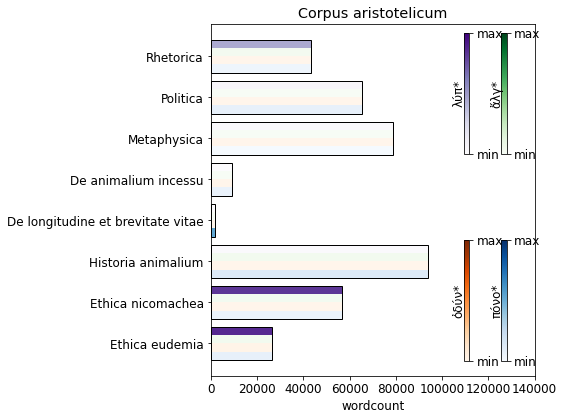

In [314]:
fig, ax = plt.subplots(figsize=(8, 6), tight_layout=True)

# CORPUS ARISTOTELICUM
labels = c_aristotelicum_10["title"].tolist()
wordcounts = c_aristotelicum_10["wordcount"]
y = np.arange(len(labels))  # the label locations
width = 0.2  # the width of the bars

bar_location = 0
for keyterm, colormap in [("λύπ*", "Purples"), ("ἄλγ*", "Greens"), ("ὀδύν*", "Oranges"), ("πόνο*", "Blues")]:
  coloring = c_aristotelicum_10[keyterm + "_TF"] / c_aristotelicum_10["TF_sum"].max()
  ax.barh(y + 0.3 - bar_location, wordcounts, width, color=plt.get_cmap(colormap)(coloring), label=keyterm)
  bar_location = bar_location + 0.2
ax.barh(y, wordcounts, width * 4, color="none", edgecolor="black")

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_title("Corpus aristotelicum")

ax.set_xlabel("wordcount")
#ax1.set_ylabel("documents")
ax.set_yticks(y)
ax.set_yticklabels(labels)
ax.set_xlim(0, 140000)
# ax.legend()

cblocs =    [[0.815, 0.63, 0.01, 0.28],# [left, bottom, width, height]
             [0.88, 0.63, 0.01, 0.28],
             [0.815, 0.15, 0.01, 0.28],
             [0.88, 0.15, 0.01, 0.28]]

for keyterm, colormap, location in [("λύπ*", "Purples", cblocs[0]), ("ἄλγ*", "Greens", cblocs[1]), ("ὀδύν*", "Oranges", cblocs[2]),	("πόνο*", "Blues", cblocs[3])]:
  cmap = plt.get_cmap(colormap)
  sm = plt.cm.ScalarMappable(cmap=cmap)
  cbaxes = fig.add_axes(location) # [left, bottom, width, height]
  cb = plt.colorbar(sm, cax=cbaxes) #shrink=0.2) #, ticks=np.arange(0,n))
  cb.set_ticks([0,1])
  cb.set_ticklabels(["min", "max"])
  cb.set_label(keyterm, labelpad=-50)


#fig.tight_layout()

plt.show()

In [315]:
#uncomment to export:
#sddk.write_file("public_data/PIA/terms-colorbar_arist.png", fig, conf)

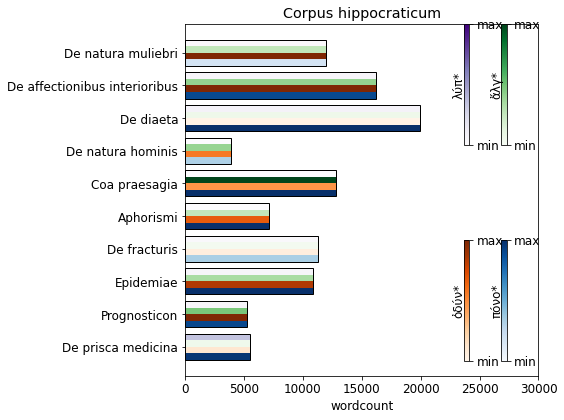

In [316]:
fig, ax = plt.subplots(figsize=(8, 6), tight_layout=True)

# CORPUS HIPPOCRATICUM
labels = c_hippocraticum_10["title"].tolist()
wordcounts = c_hippocraticum_10["wordcount"]
y = np.arange(len(labels))  # the label locations
width = 0.2  # the width of the bars

bar_location = 0
for keyterm, colormap in [("λύπ*", "Purples"), ("ἄλγ*", "Greens"), ("ὀδύν*", "Oranges"), ("πόνο*", "Blues")]:
  coloring = c_hippocraticum_10[keyterm + "_TF"] / c_aristotelicum_10["TF_sum"].max()
  ax.barh(y + 0.3 - bar_location, wordcounts, width, color=plt.get_cmap(colormap)(coloring), label=keyterm)
  bar_location = bar_location + 0.2
ax.barh(y, wordcounts, width * 4, color="none", edgecolor="black")
#rects2 = ax.barh(x + width/2, lemmata_wordcounts_1, width, label='Women')

ax.set_title("Corpus hippocraticum")
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel("wordcount")
#ax1.set_ylabel("documents")
ax.set_yticks(y)
ax.set_yticklabels(labels)
ax.set_xlim(0, 30000)
# ax.legend()

cblocs =    [[0.815, 0.65, 0.01, 0.28],# [left, bottom, width, height]
             [0.88, 0.65, 0.01, 0.28],
             [0.815, 0.15, 0.01, 0.28],
             [0.88, 0.15, 0.01, 0.28]]

for keyterm, colormap, location in [("λύπ*", "Purples", cblocs[0]), ("ἄλγ*", "Greens", cblocs[1]), ("ὀδύν*", "Oranges", cblocs[2]),	("πόνο*", "Blues", cblocs[3])]:
  cmap = plt.get_cmap(colormap)
  sm = plt.cm.ScalarMappable(cmap=cmap)
  cbaxes = fig.add_axes(location) # [left, bottom, width, height]
  cb = plt.colorbar(sm, cax=cbaxes) #shrink=0.2) #, ticks=np.arange(0,n))
  cb.set_ticks([0,1])
  cb.set_ticklabels(["min", "max"])
  cb.set_label(keyterm, labelpad=-50)


#fig.tight_layout()

plt.show()

In [317]:
#uncomment to export:
#sddk.write_file("public_data/PIA/terms-colorbar_hipp.png", fig, conf)

# Combined barplot


In [318]:
category_colors = ["Purple", "Green", "Blue", "Red"]

In [319]:
def plot_ratios(corpus_df):
  data = {}
  for n in range(len(corpus_df)):
    label = corpus_df.iloc[n]["title"].partition(";")[0].partition(".")[0] + " (" + str(corpus_df.iloc[n]["wordcount"]) + " words)"
    counts = corpus_df.iloc[n][["λύπ*", "ἄλγ*", "ὀδύν*", "πόνο*"]].tolist()
    values = corpus_df.iloc[n][["λύπ*_TF", "ἄλγ*_TF", "ὀδύν*_TF", "πόνο*_TF"]].tolist()
    values = [0 if math.isnan(x) else x for x in values]
    ratios = [val / corpus_df.iloc[n]["TF_sum"] * 100 for val in  values] # if val > 0]
    ratios = [0 if math.isnan(x) else x for x in ratios]
    data[label] = (counts, ratios)

  labels = list(data.keys())
  counts = np.array([el[0] for el in list(data.values())])
  ratios = np.array([el[1] for el in list(data.values())])
  ratios_cum = ratios.cumsum(axis=1)

  category_colors = ["Purple", "Green", "Blue", "Red"]

  terms = ["λύπ*", "ἄλγ*","ὀδύν*", "πόνο*"]


  fig, ax = plt.subplots(figsize=(12, len(corpus_df)/4 + 1), tight_layout=True)
  ax.invert_yaxis()
  ax.xaxis.set_visible(False)

  ax.set_xlim(0, np.sum(ratios, axis=1).max())
  ax.set_ylim(-0.5, len(corpus_df) - 0.5)

  for i, (term, color) in enumerate(zip(terms, category_colors)):
          widths = ratios[:, i]
          texts = counts[:, i]
          starts = ratios_cum[:, i] - widths
          ax.barh(labels, widths, left=starts,
                  label=term, color=color)
          xcenters = starts + widths / 2
          for y, (x, c) in enumerate(zip(xcenters, texts)):
              if int(c) > 0:
                ax.text(x, y, str(int(c)), ha='center', va='center', color='white')
              else:
                ax.text(x, y, "", ha='center', va='center', color='white')
  ax.legend(ncol=len(terms), bbox_to_anchor=(0, 1), loc='lower left', fontsize='small')
  return fig

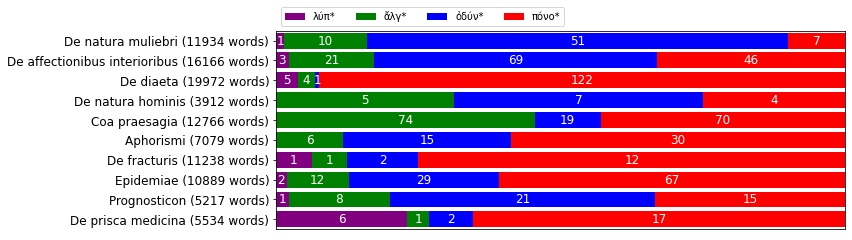

In [320]:
fig = plot_ratios(c_hippocraticum_10)

In [321]:
# uncomment to generate figures & export them to sciencedata
# sddk.write_file("public_data/PIA/ratios_c_aristotelicum.png", plot_ratios(c_aristotelicum), conf)
# sddk.write_file("public_data/PIA/ratios_c_aristotelicum_10.png", plot_ratios(c_aristotelicum_10), conf)
# sddk.write_file("public_data/PIA/ratios_c_hippocraticum.png", plot_ratios(c_hippocraticum), conf)
#sddk.write_file("public_data/PIA/ratios_c_hippocraticum_10.png", plot_ratios(c_hippocraticum_10), conf)

# Work types / document clustering

In [322]:
# add metadata for work categories
# we work 
c_hip_metadata = PIA_overview.worksheet("c_hip_metadata").get_all_records()
c_hip_cat_dict_jouanna = {pair["doc_id"] : pair["work_category"] for pair in c_hip_metadata}
c_hip_cat_dict_craik = {pair["doc_id"] : pair["title_category_Craik"] for pair in c_hip_metadata}
c_hip_cat_dict_linka = {pair["doc_id"] : pair["work_category_vojta"] for pair in c_hip_metadata}
c_hip_cat_dict_linka

{'tlg0627.tlg001': 'Theoretical',
 'tlg0627.tlg002': 'Other',
 'tlg0627.tlg003': 'Practical',
 'tlg0627.tlg004': 'Other',
 'tlg0627.tlg005': 'Other',
 'tlg0627.tlg006': 'Practical',
 'tlg0627.tlg007': 'Other',
 'tlg0627.tlg008': 'Other',
 'tlg0627.tlg009': 'Practical',
 'tlg0627.tlg010': 'Other',
 'tlg0627.tlg011': 'Other',
 'tlg0627.tlg012': 'Theoretical',
 'tlg0627.tlg013': 'Other',
 'tlg0627.tlg014': 'Other',
 'tlg0627.tlg015': 'Other',
 'tlg0627.tlg016': 'Other',
 'tlg0627.tlg017': 'Practical',
 'tlg0627.tlg018': 'Other',
 'tlg0627.tlg019': 'Theoretical',
 'tlg0627.tlg020': 'Other',
 'tlg0627.tlg021': 'Other',
 'tlg0627.tlg022': 'Other',
 'tlg0627.tlg023': 'Other',
 'tlg0627.tlg024': 'Other',
 'tlg0627.tlg025': 'Other',
 'tlg0627.tlg026': 'Other',
 'tlg0627.tlg027': 'Other',
 'tlg0627.tlg028': 'Other',
 'tlg0627.tlg029': 'Other',
 'tlg0627.tlg030': 'Other',
 'tlg0627.tlg031': 'Theoretical',
 'tlg0627.tlg032': 'Other',
 'tlg0627.tlg033': 'Practical',
 'tlg0627.tlg035': 'Other',
 'tl

In [323]:
c_hippocraticum["work_cat_jouanna"] = c_hippocraticum.apply(lambda row: c_hip_cat_dict_jouanna[row["doc_id"]], axis=1)
c_hippocraticum["work_cat_craik"] = c_hippocraticum.apply(lambda row: c_hip_cat_dict_craik[row["doc_id"]], axis=1)
c_hippocraticum["work_cat_linka"] = c_hippocraticum.apply(lambda row: c_hip_cat_dict_linka[row["doc_id"]], axis=1)

c_hippocraticum.head(5)

,filename,author,title,string,wordcount,author_id,doc_id,raw_date,date_avr,date_probs,...,πόνο*,terms_sum,λύπ*_TF,ἄλγ*_TF,ὀδύν*_TF,πόνο*_TF,TF_sum,work_cat_jouanna,work_cat_craik,work_cat_linka
1039,tlg0627.tlg001.perseus-grc1.xml,Hippocrates,De prisca medicina,ὁπόσοι μὲν ἐπεχείρησαν περὶ ἰητρικῆς λέγειν ἢ ...,5534,tlg0627,tlg0627.tlg001,5-4 B.C.,-4.0,"{'-4.5': 0.5, '-3.5': 0.5}",...,17,26,0.001084,0.000181,0.000361,0.003072,0.004698,(Anti)philosophical,Scientific principles,Theoretical
1040,tlg0627.tlg002.perseus-grc1.xml,Hippocrates,De aëre aquis et locis,"ἰητρικὴν ὅστις βούλεται ὀρθῶς ζητεῖν, τάδε χρὴ...",7502,tlg0627,tlg0627.tlg002,5-4 B.C.,-4.0,"{'-4.5': 0.5, '-3.5': 0.5}",...,1,2,0.000000,0.000000,0.000133,0.000133,0.000267,Itinerant physician,Scientific principles,Other
1041,tlg0627.tlg003.perseus-grc1.xml,Hippocrates,Prognosticon,τὸν ἰητρὸν δοκέει μοι ἄριστον εἶναι πρόνοιαν ἐ...,5217,tlg0627,tlg0627.tlg003,5-4 B.C.,-4.0,"{'-4.5': 0.5, '-3.5': 0.5}",...,15,45,0.000192,0.001533,0.004025,0.002875,0.008626,Prognostics,Cases and signs,Practical
1042,tlg0627.tlg004.perseus-grc1.xml,Hippocrates,De diaeta in morbis acutis,"οἱ ξυγγράψαντες τὰς Κνιδίας καλεομένας γνώμας,...",6128,tlg0627,tlg0627.tlg004,5-4 B.C.,-4.0,"{'-4.5': 0.5, '-3.5': 0.5}",...,13,32,0.000000,0.000653,0.002448,0.002121,0.005222,Prognostics,"Nosology, pathology, therapy",Other
1043,tlg0627.tlg005.perseus-grc1.xml,Hippocrates,De diaeta acutorum (Sp.),"καῦσος γίγνεται, ὁκόταν ἀναξηρανθέντα τὰ φλέβι...",5218,tlg0627,tlg0627.tlg005,5-4 B.C.,-4.0,"{'-4.5': 0.5, '-3.5': 0.5}",...,12,39,0.000767,0.003450,0.000958,0.002300,0.007474,Other,"Nosology, pathology, therapy",Other


In [324]:
# uncomment to export overview data to gsheet
#set_with_dataframe(PIA_overview.add_worksheet("c_aristotelicum_20201030",1,1), c_aristotelicum.drop(['string','lemmata', 'lemmatized_sentences', 'lemmatized_sentences_repl', 'lemmata_repl'], axis=1))
#set_with_dataframe(PIA_overview.add_worksheet("c_hippocraticum_20201030",1,1), c_hippocraticum.drop(['string','lemmata', 'lemmatized_sentences', 'lemmatized_sentences_repl', 'lemmata_repl'], axis=1))

In [325]:
cats_jouanna = sorted(c_hippocraticum["work_cat_jouanna"].unique().tolist())
cats_jouanna

['(Anti)philosophical',
 'Aphorisms',
 'Cnidan',
 'Dietetics',
 'Epidemics',
 'Female medicine',
 'Itinerant physician',
 'Later',
 'Other',
 'Prognostics',
 'Surgical']

In [326]:
cats_craig = sorted(c_hippocraticum["work_cat_craik"].unique().tolist())
cats_craig

['Anatomy and physiology',
 'Cases and signs',
 'Guidance and ideals',
 'Gynaecology and embryology',
 'Nosology, pathology, therapy',
 'Scientific principles',
 'Surgery']

In [327]:
cats_linka = sorted(c_hippocraticum["work_cat_linka"].unique().tolist(), reverse=True)
cats_linka

['Theoretical', 'Practical', 'Other']

In [328]:
cat_dfs = {}
for category_column in ["work_cat_jouanna", "work_cat_craik", "work_cat_linka"]:
    cat_df = c_hippocraticum.groupby(category_column).sum().drop(['date_avr', 'date_manual', "λύπ*_TF", "ἄλγ*_TF", "ὀδύν*_TF", "πόνο*_TF", 'TF_sum'], axis=1)
    cat_df["N_docs"] = c_hippocraticum.groupby(category_column).size()
    for term in ["λύπ*", "ἄλγ*", "ὀδύν*", "πόνο*"]:
        cat_df[term + "_TF"] = cat_df.apply(lambda row: np.round(row[term] / row["wordcount"], 6), axis=1)
        cat_df[term + "_TF"] = cat_df.apply(lambda row: np.round(row[term] / row["wordcount"], 6), axis=1)
    cat_df["TF_sum"] = cat_df.apply(lambda row: np.round((row["λύπ*"] + row["ἄλγ*"] + row["ὀδύν*"] + row["πόνο*"]) / row["wordcount"], 6), axis=1)
    cat_dfs[category_column] = cat_df

In [329]:
cat_dfs["work_cat_linka"] = cat_dfs["work_cat_linka"].sort_index(ascending=False)
cat_dfs["work_cat_linka"]

,wordcount,lemmata_wordcount,n_sentences,λύπ*,ἄλγ*,ὀδύν*,πόνο*,terms_sum,N_docs,λύπ*_TF,ἄλγ*_TF,ὀδύν*_TF,πόνο*_TF,TF_sum
work_cat_linka,,,,,,,,,,,,,,
Theoretical,36497,18070,2504,11,16,25,173,225,4,0.000301,0.000438,0.000685,0.004740,0.006165
Practical,52044,28928,5044,5,105,122,171,403,5,0.000096,0.002018,0.002344,0.003286,0.007743
Other,244905,124235,16911,42,194,495,307,1038,43,0.000171,0.000792,0.002021,0.001254,0.004238


In [330]:
cat_dfs["work_cat_craik"]

,wordcount,lemmata_wordcount,n_sentences,λύπ*,ἄλγ*,ὀδύν*,πόνο*,terms_sum,N_docs,λύπ*_TF,ἄλγ*_TF,ὀδύν*_TF,πόνο*_TF,TF_sum
work_cat_craik,,,,,,,,,,,,,,
Anatomy and physiology,20295,9507,1331,2,15,32,28,77,7,0.000099,0.000739,0.001577,0.001380,0.003794
Cases and signs,33481,17920,3032,7,62,111,103,283,7,0.000209,0.001852,0.003315,0.003076,0.008453
Guidance and ideals,40501,21610,3933,9,85,38,110,242,11,0.000222,0.002099,0.000938,0.002716,0.005975
Gynaecology and embryology,73312,41107,5296,5,68,164,79,316,7,0.000068,0.000928,0.002237,0.001078,0.004310
"Nosology, pathology, therapy",70273,35864,4725,17,75,271,149,512,5,0.000242,0.001067,0.003856,0.002120,0.007286
Scientific principles,46689,21820,3068,17,8,5,159,189,7,0.000364,0.000171,0.000107,0.003406,0.004048
Surgery,48895,23405,3074,1,2,21,23,47,8,0.000020,0.000041,0.000429,0.000470,0.000961


In [331]:
for key in cat_dfs.keys():
    try:
        set_with_dataframe(PIA_overview.add_worksheet(key, 1, 1), cat_dfs[key])
    except:
        set_with_dataframe(PIA_overview.worksheet(key), cat_dfs[key])

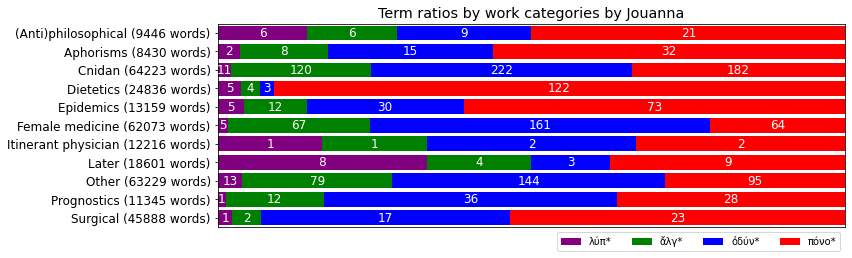

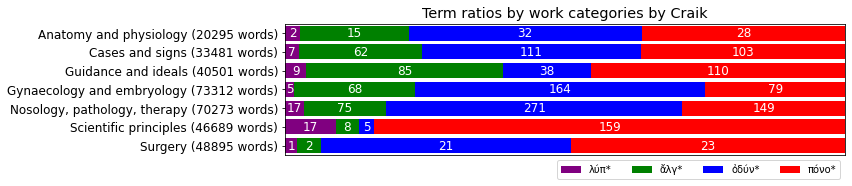

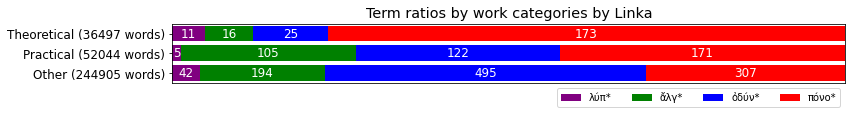

In [332]:
keys_figs_tups = []

for key in cat_dfs.keys():
    # extract the dataframe (in reverse order)
    c_hippocraticum_by_cat = cat_dfs[key][::-1]
    # prepare the data
    data, labels, counts, ratios = [], [], [], [] # prepare for empty lists 
    for n in range(len(c_hippocraticum_by_cat)):
        label = str(c_hippocraticum_by_cat.index[n]) + " (" + str(int(c_hippocraticum_by_cat.iloc[n]["wordcount"])) + " words)"
        labels.append(label)
        cat_counts = c_hippocraticum_by_cat.iloc[n][["λύπ*", "ἄλγ*", "ὀδύν*", "πόνο*"]].tolist()
        counts.append(cat_counts)
        cat_ratios = [val / c_hippocraticum_by_cat.iloc[n]["terms_sum"] * 100 for val in  cat_counts] # if val > 0]
        cat_ratios = [0 if math.isnan(x) else x for x in cat_ratios]
        ratios.append(cat_ratios)
    # extract the dataframe (in reverse order)
    counts = np.array(counts)
    ratios = np.array(ratios)
    ratios_cum = ratios.cumsum(axis=1)
    category_colors = ["Purple", "Green", "Blue", "Red"]
    terms = ["λύπ*", "ἄλγ*","ὀδύν*", "πόνο*"]

    fig, ax = plt.subplots(figsize=(12, (len(c_hippocraticum_by_cat) / 4) + 1), tight_layout=True)
    ax.invert_yaxis()
    ax.xaxis.set_visible(False)

    ax.set_xlim(0, np.sum(ratios, axis=1).max())
    ax.set_ylim(-0.5, len(c_hippocraticum_by_cat) - 0.5)

    for i, (term, color) in enumerate(zip(terms, category_colors)):
              widths = ratios[:, i]
              texts = counts[:, i]
              starts = ratios_cum[:, i] - widths
              ax.barh(labels, widths, left=starts,
                      label=term, color=color)
              xcenters = starts + widths / 2
              for y, (x, c) in enumerate(zip(xcenters, texts)):
                  if int(c) > 0:
                    ax.text(x, y, str(int(c)), ha='center', va='center', color='white')
                  else:
                    ax.text(x, y, "", ha='center', va='center', color='white')
    ax.legend(ncol=len(terms), bbox_to_anchor=(1, 0), fontsize='small') # loc='lower left'
    
    ax.set_title("Term ratios by work categories by " + key.rpartition("_")[2].capitalize())
    keys_figs_tups.append((key, fig))


In [165]:
for key_fig in keys_figs_tups:
    sddk.write_file("public_data/PIA/c_hip_ratios_by_cat_{0}.png".format(key_fig[0].rpartition("_")[2]), key_fig[1], conf)

A file with the same name ("c_hip_ratios_by_cat_jouanna.png") already exists in this location.
Press Enter to overwrite it or choose different path and filename: 
Your <class 'matplotlib.figure.Figure'> object has been succefully written as "https://sciencedata.dk/files/public_data/PIA/c_hip_ratios_by_cat_jouanna.png"
A file with the same name ("c_hip_ratios_by_cat_craik.png") already exists in this location.
Press Enter to overwrite it or choose different path and filename: 
Your <class 'matplotlib.figure.Figure'> object has been succefully written as "https://sciencedata.dk/files/public_data/PIA/c_hip_ratios_by_cat_craik.png"
A file with the same name ("c_hip_ratios_by_cat_linka.png") already exists in this location.
Press Enter to overwrite it or choose different path and filename: 
Your <class 'matplotlib.figure.Figure'> object has been succefully written as "https://sciencedata.dk/files/public_data/PIA/c_hip_ratios_by_cat_linka.png"


# Document distances

In [333]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD 
from sklearn.metrics.pairwise import cosine_similarity

In [334]:
c_hippocraticum.columns

Index(['filename', 'author', 'title', 'string', 'wordcount', 'author_id',
       'doc_id', 'raw_date', 'date_avr', 'date_probs', 'date_manual',
       'provenience', 'sentences', 'lemmata', 'lemmata_wordcount',
       'lemmatized_sentences', 'n_sentences', 'lemmata_repl',
       'lemmatized_sentences_repl', 'λύπ*', 'ἄλγ*', 'ὀδύν*', 'πόνο*',
       'terms_sum', 'λύπ*_TF', 'ἄλγ*_TF', 'ὀδύν*_TF', 'πόνο*_TF', 'TF_sum',
       'work_cat_jouanna', 'work_cat_craik', 'work_cat_linka'],
      dtype='object')

In [335]:
# as an input for vectorization, we need the documents in a form of strings
# we need two lists:
# (1) list of strings
# (2) list of work names
strings = [" ".join(lemmata) for lemmata in c_hippocraticum["lemmata"].tolist()]
titles = c_hippocraticum["title"].tolist()

In [336]:
def make_vec_df(list_of_string_docs, doc_names):
  vec = CountVectorizer()
  X = vec.fit_transform(list_of_string_docs)
  vectorization_df = pd.DataFrame(X.toarray(), columns=vec.get_feature_names(), index=doc_names)
  cosine_sim = cosine_similarity(X.toarray()) 
  cosine_sim_df = pd.DataFrame(np.round(cosine_sim, 5), columns=doc_names, index=doc_names)
  cosine_dist = 1 - cosine_similarity(X.toarray())
  cosine_dist_df = pd.DataFrame(np.round(cosine_dist, 5), columns=doc_names, index=doc_names)
  return [vectorization_df, cosine_sim_df, cosine_dist_df, doc_names]

In [337]:
c_hip_vec = make_vec_df(strings, titles)
c_hip_vec[0]

,άδες,άμα,έα,έκάτερα,έλκος,έᾷν,ήγο,ήμισαπές,ίνεται,αʼ,...,ῥᾷόν,ῥῆγμα,ῥῆμα,ῥῆξαί,ῥῆξις,ῥῆσις,ῥῖγος,ῥῖγός,ῥῖψις,ῥῦπος
De prisca medicina,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,2,0,0,0
De aëre aquis et locis,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
Prognosticon,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
De diaeta in morbis acutis,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
De diaeta acutorum (Sp.),0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Epidemiae,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,13,0,0,0
De capitis vulneribus,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
De officina medici,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
De fracturis,0,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
De articulis,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [338]:
c_hip_vec[2]

,De prisca medicina,De aëre aquis et locis,Prognosticon,De diaeta in morbis acutis,De diaeta acutorum (Sp.),Epidemiae,De capitis vulneribus,De officina medici,De fracturis,De articulis,...,De corde,De alimento,De visu,De ossium natura,De medico,De decente habitu,Praeceptiones,De judicationibus,De diebus judicatoriis,Epistulae
De prisca medicina,0.00000,0.42148,0.50592,0.48387,0.62001,0.58052,0.73412,0.71361,0.61197,0.51649,...,0.61071,0.66304,0.70187,0.80778,0.61046,0.58405,0.61108,0.60377,0.57495,0.46482
De aëre aquis et locis,0.42148,0.00000,0.50047,0.50926,0.50905,0.62960,0.70452,0.70833,0.62538,0.54845,...,0.63581,0.74768,0.66352,0.77374,0.64781,0.71642,0.68240,0.58720,0.52493,0.52374
Prognosticon,0.50592,0.50047,0.00000,0.39217,0.40257,0.59198,0.64538,0.73203,0.46657,0.41822,...,0.72592,0.76376,0.57956,0.79262,0.64630,0.68552,0.64215,0.31369,0.42420,0.60494
De diaeta in morbis acutis,0.48387,0.50926,0.39217,0.00000,0.41417,0.61757,0.69321,0.65053,0.46109,0.43412,...,0.68751,0.72045,0.63223,0.76778,0.59161,0.60125,0.54941,0.51877,0.51353,0.54290
De diaeta acutorum (Sp.),0.62001,0.50905,0.40257,0.41417,-0.00000,0.64434,0.68079,0.74640,0.54744,0.49814,...,0.72511,0.81116,0.55955,0.76722,0.74468,0.81076,0.68369,0.41856,0.42223,0.73128
Epidemiae,0.58052,0.62960,0.59198,0.61757,0.64434,0.00000,0.83244,0.77574,0.73705,0.71278,...,0.79772,0.77319,0.78500,0.83450,0.72002,0.68383,0.75043,0.51117,0.67094,0.66015
De capitis vulneribus,0.73412,0.70452,0.64538,0.69321,0.68079,0.83244,0.00000,0.75664,0.31175,0.43017,...,0.84567,0.81205,0.60598,0.79556,0.74132,0.82768,0.80710,0.72823,0.69940,0.78635
De officina medici,0.71361,0.70833,0.73203,0.65053,0.74640,0.77574,0.75664,0.00000,0.58172,0.55084,...,0.81684,0.75792,0.76561,0.72411,0.69610,0.81078,0.78572,0.76925,0.76206,0.73914
De fracturis,0.61197,0.62538,0.46657,0.46109,0.54744,0.73705,0.31175,0.58172,0.00000,0.18375,...,0.77447,0.75780,0.58596,0.71972,0.59486,0.64425,0.68007,0.65258,0.60457,0.65884
De articulis,0.51649,0.54845,0.41822,0.43412,0.49814,0.71278,0.43017,0.55084,0.18375,0.00000,...,0.74160,0.74868,0.55395,0.66599,0.57994,0.64399,0.64783,0.59387,0.52371,0.60423


In [339]:
# https://matplotlib.org/3.1.0/gallery/color/named_colors.html
import matplotlib.colors as mcolors
colors_list = list(mcolors.TABLEAU_COLORS.keys()) + list(mcolors.BASE_COLORS.keys())
print(colors_list)

['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan', 'b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']


In [340]:
cat_dfs.keys()

dict_keys(['work_cat_jouanna', 'work_cat_craik', 'work_cat_linka'])

In [342]:
list(cat_dfs.keys())

['work_cat_jouanna', 'work_cat_craik', 'work_cat_linka']

In [343]:
color_keys = c_hippocraticum["work_cat_linka"].unique().tolist()
color_values = tab_colors_list[:len(color_keys)]
works_colors_dict = dict(zip(color_keys, color_values))

In [344]:
import matplotlib.pyplot as plt
from sklearn.manifold import MDS

plt.rcParams['figure.figsize'] = (12.0, 12.0)
plt.rcParams.update({'font.size': 12})

data = c_hip_vec[2]

mds = MDS(n_components=2, random_state=1, dissimilarity='precomputed') # dissimilarity="precomputed",
pos = mds.fit_transform(data)
xs, ys = pos[:, 0], pos[:, 1]

keys_figs = []

def plot_distances_by_cats(work_cat_col, title="" ,xlim_tup = (-1, 1), bbox_to_anchor=(0.73, 1), loc='upper left'):
    cat_author = work_cat_col.rpartition("_")[2].capitalize()
    fig, ax = plt.subplots()
    color_keys = c_hippocraticum[work_cat_col].unique().tolist()
    color_values = colors_list[:len(color_keys)]
    works_colors_dict = dict(zip(color_keys, color_values))
    work_colors = list(c_hippocraticum[work_cat_col].apply(lambda x: works_colors_dict[x]))
    for x, y, name, color in zip(xs, ys, data.columns, work_colors):
        ax.scatter(x, y, c=np.array([color]))
        x = x- (0.006 * len(name))
        ax.text(x, y+0.01, name)
    ax.set_xlim(xlim_tup)
    ax.set_title(title)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    
    markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in color_values]
    plt.legend(markers, color_keys, numpoints=1,  title="Work categories", bbox_to_anchor=bbox_to_anchor, loc=loc)

    keys_figs.append([cat_author, fig])
    return fig
    #plt.legend(color_pairs.values(), color_pairs.keys(), bbox_to_anchor=(1, 1), loc='upper left')

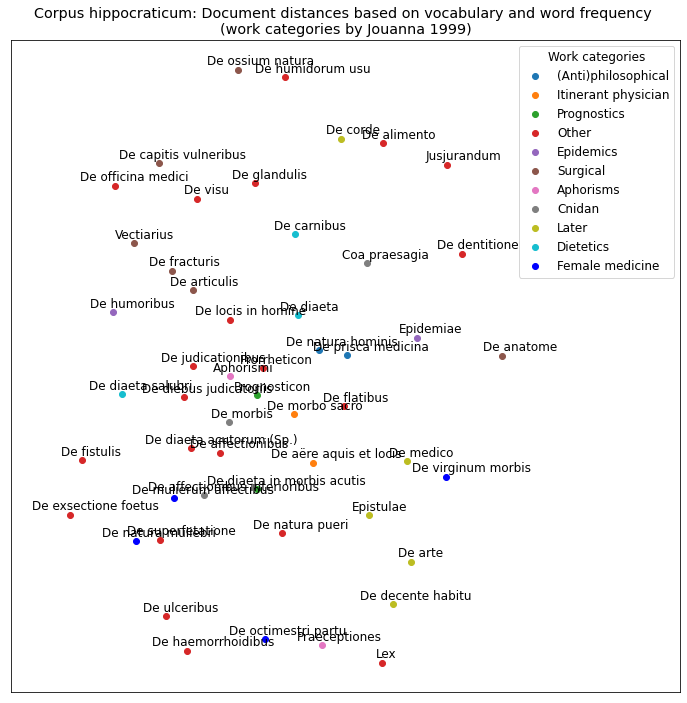

In [345]:
title = "Corpus hippocraticum: Document distances based on vocabulary and word frequency \n(work categories by Jouanna 1999)"
fig = plot_distances_by_cats("work_cat_jouanna", title=title,xlim_tup = (-0.8, 1.3), bbox_to_anchor=(1, 1), loc='upper right')

In [346]:
sddk.write_file("public_data/PIA/c_hip_distances_by_cat_jouanna.png", fig, conf)

A file with the same name ("c_hip_distances_by_cat_jouanna.png") already exists in this location.
Press Enter to overwrite it or choose different path and filename: 
Your <class 'matplotlib.figure.Figure'> object has been succefully written as "https://sciencedata.dk/files/public_data/PIA/c_hip_distances_by_cat_jouanna.png"


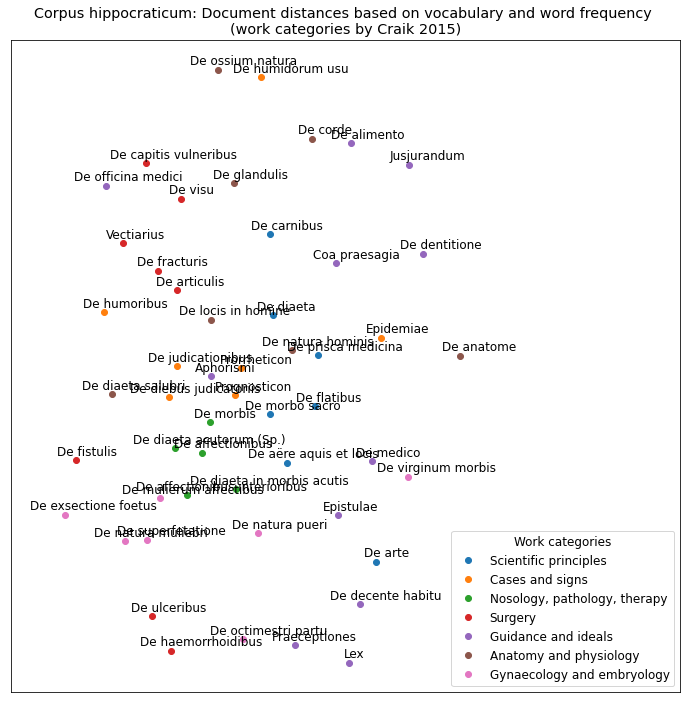

In [347]:
title =  "Corpus hippocraticum: Document distances based on vocabulary and word frequency \n(work categories by Craik 2015)"
fig = plot_distances_by_cats("work_cat_craik", title = title,xlim_tup = (-0.8, 1.5), bbox_to_anchor=(1, 0), loc='lower right')

In [348]:
sddk.write_file("public_data/PIA/c_hip_distances_by_cat_craik.png", fig, conf)

A file with the same name ("c_hip_distances_by_cat_craik.png") already exists in this location.
Press Enter to overwrite it or choose different path and filename: 
Your <class 'matplotlib.figure.Figure'> object has been succefully written as "https://sciencedata.dk/files/public_data/PIA/c_hip_distances_by_cat_craik.png"


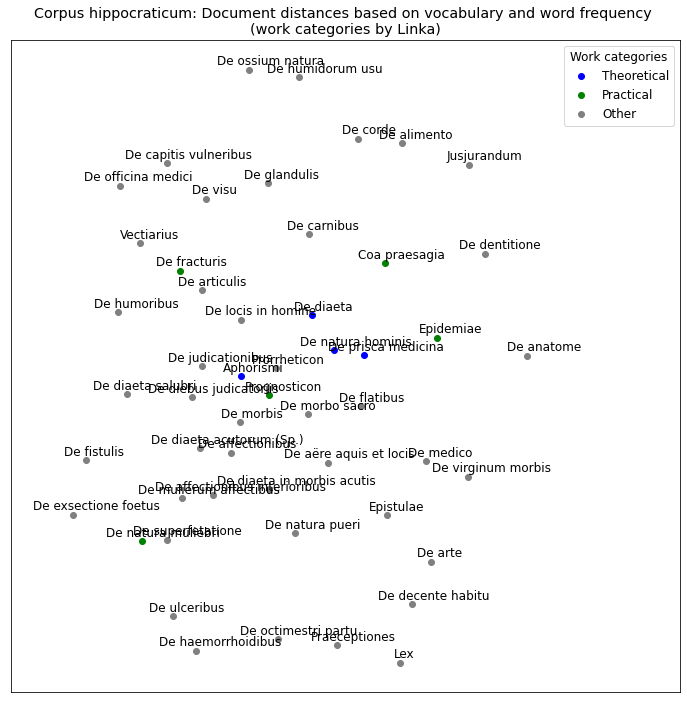

In [349]:
work_cat_col = "work_cat_linka"

fig, ax = plt.subplots()
color_keys = sorted(c_hippocraticum[work_cat_col].unique().tolist(), reverse=True)
color_values = ["blue", "green", "gray"]
works_colors_dict = dict(zip(color_keys, color_values))
work_colors = list(c_hippocraticum[work_cat_col].apply(lambda x: works_colors_dict[x]))
for x, y, name, color in zip(xs, ys, data.columns, work_colors):
        ax.scatter(x, y, c=np.array([color]))
        x = x- (0.006 * len(name))
        ax.text(x, y+0.01, name)
ax.set_xlim(-0.8, 1.2)
ax.set_title("Corpus hippocraticum: Document distances based on vocabulary and word frequency \n(work categories by Linka)")
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
    
markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in color_values]
plt.legend(markers, color_keys, numpoints=1,  title="Work categories", bbox_to_anchor=(1, 1), loc='upper right')

In [350]:
sddk.write_file("public_data/PIA/c_hip_distances_by_cat_linka.png", fig, conf)

A file with the same name ("c_hip_distances_by_cat_linka.png") already exists in this location.
Press Enter to overwrite it or choose different path and filename: 
Your <class 'matplotlib.figure.Figure'> object has been succefully written as "https://sciencedata.dk/files/public_data/PIA/c_hip_distances_by_cat_linka.png"


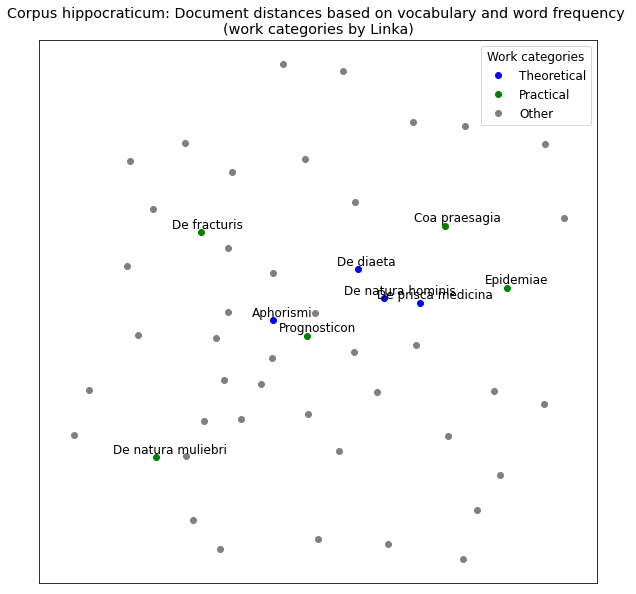

In [351]:
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.rcParams.update({'font.size': 12})

fig, ax = plt.subplots()
color_keys = sorted(c_hippocraticum[work_cat_col].unique().tolist(), reverse=True)
color_values = ["blue", "green", "gray"]
works_colors_dict = dict(zip(color_keys, color_values))
work_colors = list(c_hippocraticum[work_cat_col].apply(lambda x: works_colors_dict[x]))
for x, y, name, color in zip(xs, ys, data.columns, work_colors):
    ax.scatter(x, y, c=np.array([color]))
    if color in ["blue", "green"]: 
        x = x- (0.006 * len(name))
        ax.text(x, y+0.01, name)
ax.set_xlim(-0.7,0.7)
ax.set_title("Corpus hippocraticum: Document distances based on vocabulary and word frequency \n(work categories by Linka)")
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
    
markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in color_values]
plt.legend(markers, color_keys, numpoints=1,  title="Work categories", bbox_to_anchor=(1, 1), loc='upper right')

In [352]:
sddk.write_file("public_data/PIA/c_hip_distances_by_cat_linka_unlabeled.png", key, conf)

A file with the same name ("c_hip_distances_by_cat_linka_unlabeled.png") already exists in this location.
Press Enter to overwrite it or choose different path and filename: 
Your <class 'str'> object has been succefully written as "https://sciencedata.dk/files/public_data/PIA/c_hip_distances_by_cat_linka_unlabeled.png"


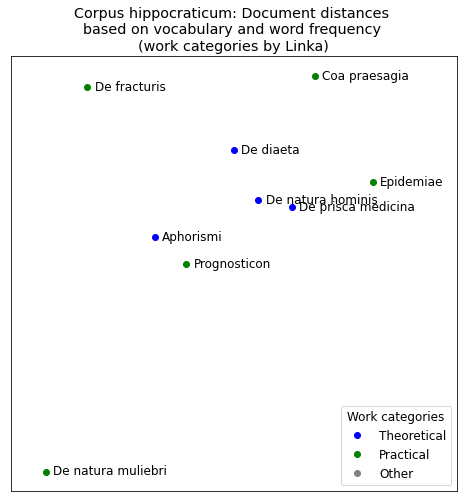

In [353]:
plt.rcParams['figure.figsize'] = (8.0, 8.0)
plt.rcParams.update({'font.size': 12})

fig, ax = plt.subplots()
color_keys = sorted(c_hippocraticum[work_cat_col].unique().tolist(), reverse=True)
color_values = ["blue", "green", "gray"]
works_colors_dict = dict(zip(color_keys, color_values))
work_colors = list(c_hippocraticum[work_cat_col].apply(lambda x: works_colors_dict[x]))
for x, y, name, color in zip(xs, ys, data.columns, work_colors):
    if color in ["blue", "green"]:
        ax.scatter(x, y, c=np.array([color]))
        #x = x- (0.006 * len(name))
        ax.text(x + 0.02, y- 0.005, name)
ax.set_xlim(-0.5,0.7)
ax.set_title("Corpus hippocraticum: Document distances \nbased on vocabulary and word frequency \n(work categories by Linka)")
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
    
markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in color_values]
plt.legend(markers, color_keys, numpoints=1,  title="Work categories", bbox_to_anchor=(1, 0), loc='lower right')

In [354]:
sddk.write_file("public_data/PIA/c_hip_distances_by_cat_linka_only.png", key, conf)

A file with the same name ("c_hip_distances_by_cat_linka_only.png") already exists in this location.
Press Enter to overwrite it or choose different path and filename: 
Your <class 'str'> object has been succefully written as "https://sciencedata.dk/files/public_data/PIA/c_hip_distances_by_cat_linka_only.png"


In [355]:
sddk.write_file("public_data/PIA/c_hippocraticum_enriched.json", c_hippocraticum, conf)

A file with the same name ("c_hippocraticum_enriched.json") already exists in this location.
Press Enter to overwrite it or choose different path and filename: 
Your <class 'pandas.core.frame.DataFrame'> object has been succefully written as "https://sciencedata.dk/files/public_data/PIA/c_hippocraticum_enriched.json"
